# Accuinsight+ Modeler AutoDL tutorial
## 서울의 2019년 일별 평균 기온을 예측하는 RNN 모델
## 목차
1. [분석 개요](#RNN_분석_개요)
2. [데이터](#RNN_데이터)
3. [RNN 모델 생성 및 학습](#RNN_모델_구성_및_학습)
4. [학습 결과 시각화](#RNN_학습_결과_시각화)
5. [Modeler AutoDL 사용방법](#AutoDL_사용방법)

<a id='RNN_분석_개요'></a>
## 분석 개요
- 본 예제에서는 기상청 기상자료개방포털에서 제공하는 [서울 평균기온 데이터](https://data.kma.go.kr/stcs/grnd/grndTaList.do?pgmNo=70)를 사용해 서울의 일별 평균기온을 예측하는 2-layer RNN 모델을 만들고,  
  Accuinsight+ Modeler의 AutoDL 기능을 사용하여 하이퍼파라미터를 최적화하는 과정을 설명합니다.
- 2009년부터 2018년까지 9년 간 서울의 평균기온 데이터를 학습 데이터로 사용하여 2019년의 평균기온을 예측합니다.

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

import numpy as np
import pandas as pd
import easydict
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

<a id='RNN_데이터'></a>
## 데이터

2009년부터 2019년까지 10년 간 서울의 평균기온 데이터입니다.

In [2]:
temp = pd.read_csv("data/seoul_temperature.csv")
temp["날짜"] = pd.to_datetime(temp["날짜"])
temp = temp.set_index("날짜")
temp = pd.DataFrame(temp["평균기온(℃)"])
temp

,평균기온(℃)
날짜,
2009-01-01,-5.8
2009-01-02,-2.8
2009-01-03,-1.0
2009-01-04,0.4
2009-01-05,-1.6
...,...
2019-12-27,-1.7
2019-12-28,1.1
2019-12-29,3.8


계절성 패턴을 갖는 시계열 데이터입니다.

/opt/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


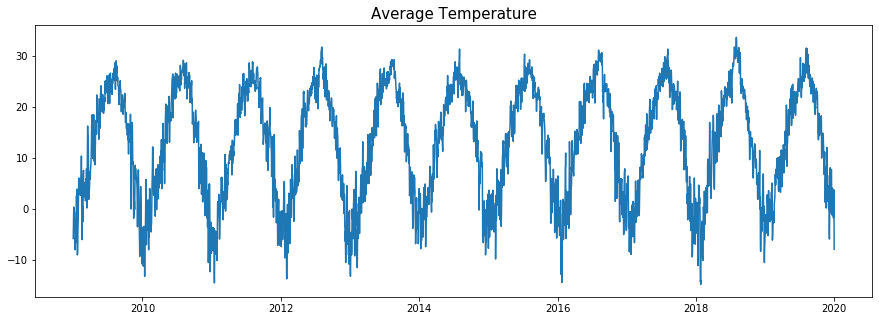

In [3]:
plt.figure(figsize=(15,5))
plt.plot(temp.index, temp["평균기온(℃)"])
plt.title('Average Temperature', fontsize=15);

#### train/test dataset 분리
- train dataset: 2009년~2018년  
- test dataset: 2019년

In [4]:
train_df = temp[:3652]
test_df = temp[3652:]

#### Min-Max Scaling

In [5]:
transformer = MinMaxScaler()
train = transformer.fit_transform(train_df)
test = transformer.transform(test_df)

<a id='하이퍼파라미터_설정'></a>
- 본 예제에서는 모델 학습과 관련된 하이퍼파라미터인 epochs, batch size, learning_rate와  
  모델 구조를 결정하는 하이퍼파라미터인 num_nodes, sequence_length, rnn_cell을 최적화합니다.
  - `num_nodes`: RNN layer의 노드 개수
  - `sequnece_length`: 예측에 사용할 과거 정보의 길이
  - `rnn_cell`: RNN, LSTM, GRU 중에서 선택 ([이미지 출처](http://dprogrammer.org/rnn-lstm-gru))
- AutoDL을 사용하기 위해서는 __argparse__를 통해 하이퍼파라미터를 설정해야 하는데,  
  jupyter notebook에서는 argparse 사용이 불가능하기 때문에 __easydict__를 통해 하이퍼파라미터를 설정합니다.  
  실제로 AutoDL에 사용되는 [autodl_rnn_temperature_regression.py](autodl_rnn_temperature_regression.py)에서는 argparse를 통해 하이퍼파라미터를 설정합니다.
<p align="center">
    <img src="pic/rnn_lstm_gru.png" height="750px" width="850px">
</p>

In [6]:
args = easydict.EasyDict({
    "sequence_length": 7,
    "num_nodes": 30,
    "rnn_cell": "LSTM",
    "learning_rate": 0.0001,
    "batch_size": 64,
    "epochs": 20})

#### sequence_length 값에 따라 데이터 재구성
- sequence_length의 default 값은 7입니다.
- sequence_length의 값이 7이면 이전 7일 간의 평균기온 데이터를 사용해 다음 날의 평균기온을 예측합니다.

In [7]:
window_length = args.sequence_length + 1

x_train = []
y_train = []
for i in range(0, len(train) - window_length + 1):
    window = train[i:i + window_length, :]
    x_train.append(window[:-1, :])
    y_train.append(window[-1, [-1]])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for i in range(0, len(test) - window_length + 1):
    window = test[i:i + window_length, :]
    x_test.append(window[:-1, :])
    y_test.append(window[-1, [-1]])
x_test = np.array(x_test)
y_test = np.array(y_test)

<a id='RNN_모델_구성_및_학습'></a>
## RNN 모델 생성 및 학습

In [8]:
if args.rnn_cell == "LSTM":
    rnn_cell = tf.keras.layers.LSTM
elif args.rnn_cell == "GRU":
    rnn_cell = tf.keras.layers.GRU
elif args.rnn_cell == "RNN":
    rnn_cell = tf.keras.layers.RNN

In [9]:
model = tf.keras.models.Sequential([
    rnn_cell(args.num_nodes, return_sequences=True, input_shape=(args.sequence_length, 1)),
    rnn_cell(args.num_nodes),
    tf.keras.layers.Dense(1)])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 30)             3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


<a id='평가지표_출력'></a>
#### 평가지표 출력
- AutoDL에서 평가 지표를 수집할 수 있도록 epoch이 종료될 때마다 평가 지표(Loss)를 출력합니다.
- 이번 예제에서는 __평가 지표명=평가 지표값__ 형식으로 평가 지표를 출력하는데,  
  평가 지표 설정 방법은 [Modeler AutoDL 사용방법](#평가지표_수집) 챕터에서 좀 더 자세히 다룰 것입니다.

In [10]:
class MetricHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("\nEpoch {}".format(epoch + 1))
        print("Train-loss={:.4f}".format(logs['loss']))
        print("Validation-loss={:.4f}".format(logs['val_loss']))

<a id='튜닝_전_결과'></a>
#### 모델 학습
- 학습 결과 validation loss는 0.0047입니다.
- 다음 챕터인 [Modeler AutoDL 사용방법](#AutoDL_사용방법) 챕터에서 AutoDL 기능으로 RNN 모델의 하이퍼파라미터를 튜닝하여 모델 성능을 향상시키는 과정을 살펴볼 것입니다.

In [11]:
model.fit(x_train, y_train,
          epochs=args.epochs,
          batch_size=args.batch_size,
          validation_split=0.2,
          shuffle=False,
          callbacks=[MetricHistory()])

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 0.0689
Epoch 1
Train-loss=0.0689
Validation-loss=0.0107
46/46 [==============================] - 1s 19ms/step - loss: 0.0689 - val_loss: 0.0107
Epoch 2/20
41/46 [=========================>....] - ETA: 0s - loss: 0.0081
Epoch 2
Train-loss=0.0078
Validation-loss=0.0064
46/46 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0064
Epoch 3/20
43/46 [===========================>..] - ETA: 0s - loss: 0.0059
Epoch 3
Train-loss=0.0059
Validation-loss=0.0054
46/46 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 4/20
43/46 [===========================>..] - ETA: 0s - loss: 0.0054
Epoch 4
Train-loss=0.0054
Validation-loss=0.0052
46/46 [==============================] - 0s 7ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 5/20
42/46 [==========================>...] - ETA: 0s - loss: 0.0054
Epoch 5
Train-loss=0.0054
Validation-loss=0.0052
46/46 [========================

<a id='RNN_학습_결과_시각화'></a>
## 학습 결과 시각화

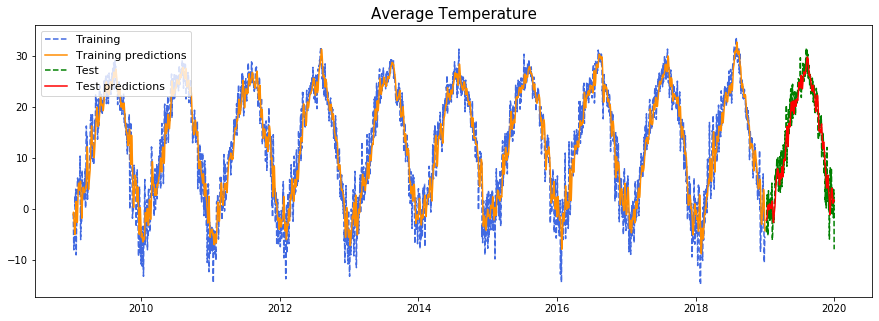

In [12]:
train_prediction = model.predict(x_train, batch_size=64)
test_prediction = model.predict(x_test, batch_size=64)
plt.figure(figsize=(15,5))
plt.plot(train_df.index[7:], transformer.inverse_transform(y_train), '--', c='royalblue',
         label='Training')
plt.plot(train_df.index[7:], transformer.inverse_transform(train_prediction), c='darkorange',
         label='Training predictions')
plt.plot(test_df.index[7:], transformer.inverse_transform(y_test), '--', c='green',
         label='Test')
plt.plot(test_df.index[7:], transformer.inverse_transform(test_prediction), c='red',
         label='Test predictions')
plt.legend(fontsize=11, loc='upper left');
plt.title('Average Temperature', fontsize=15);
plt.show()

<a id='AutoDL_사용방법'></a>
## Modeler AutoDL 사용방법
- 지금까지 서울의 일별 평균기온을 예측하는 RNN 모델 예제를 살펴보았습니다.
- 이번 챕터에서는 AutoDL 기능을 사용해 위에서 살펴본 RNN 모델의 하이퍼파라미터를 최적화하는 과정에 대해 다룰 것입니다.

#### 1. jupyter lab
- 먼저 autodl에서 하이퍼파라미터 튜닝을 수행할 파이썬 모델 파일을 작성합니다. 본 예제에서는 [autodl_rnn_temperature_regression.py](autodl_rnn_temperature_regression.py)을 사용합니다.
- 파이썬 모델 실행에 필요한 데이터들은 __filestorage__ 폴더에 업로드합니다.

<p align="center">
    <img src="pic/1_jupyter_lab.png" height="1000px" width="1200px">
</p>

#### 2. docker 이미지 빌드
- jupyter lab에서 작성한 파이썬 모델, filestorage의 데이터와 워크스페이스에 설치된 라이브러리를 포함한 docker 이미지를 빌드하는 단계입니다.
- Modeler > 관리 > AutoDL > 모델관리부 > 이미지 탭에서 우측 상단의 __[이미지 추가]__ 버튼을 클릭합니다.
- 이미지명, 파이썬 모델링에 사용된 딥러닝 프레임워크, 워크스페이스의 파이썬 모델 파일과 이미지 설명을 입력하고 __[빌드]__ 버튼을 클릭합니다.
- 이미지는 __BUILDING__ > __UPLOADING__ > __COMPLETE__ 순서로 빌딩됩니다.

<p align="center">
    <img src="pic/2_add_image.png" height="1000px" width="1200px">
</p>
<p align="center">
    <img src="pic/3_image_list.png" height="1000px" width="1200px">
</p>

<a id='trialtemplate_생성'></a>
#### 3. trialtemplate 생성
- autodl 실행에 필요한 trialtemplate을 생성하는 단계입니다. trialtemplate은 docker image 빌드와 동시에 자동으로 생성됩니다.
- Modeler > 관리 > AutoDL > 모델관리부 > Trial Template 탭에서 자동 생성된 trialtemplate을 확인할 수 있습니다.
- 이 단계에서 사용자는 사용할 자원의 양만 수정하면 됩니다.

<p align="center">
    <img src="pic/4_trialtemplate.png" height="1000px" width="1200px">
</p>

<a id='평가지표_수집'></a>
#### 4. AutoDL yaml 작성 및 experiment 실행
- 마지막으로, 하이퍼파라미터 튜닝에 사용되는 옵션들을 설정하는 yaml을 작성하여 AutoDL experiment를 실행해 보겠습니다.
- 옵션 관련 자세한 사항은 [상세 매뉴얼](https://accuinsight.github.io/docs/modeler/management/autodl/)에서 확인하실 수 있습니다.
- __Metrics Collector__  
  - RNN 모델 생성 및 학습 챕터에서 설정한 [평가 지표의 출력 형식](#평가지표_출력)과 관련된 옵션입니다.  
  - 출력된 평가 지표를 어떻게 수집할 것인지 설정합니다.
  - __StdOut__ 옵션은 metricsFormat에서 정의한 정규 표현식에 맞추어 평가 지표를 수집합니다.  
    metricsFormat의 디폴트 값인 ([\w|-]+)\s=\s((-?\d+)(.\d+)?)을 사용하면 __평가 지표명=평가 지표값__ 형식으로 출력된 평가 지표를 수집할 수 있습니다.
- __Algorithm__
  - 하이퍼파라미터 튜닝 알고리즘으로 __random__ 알고리즘을 선택합니다.
- __TrialCount__
  - AutoDL에서 trial은 하나의 하이퍼파라미터 조합을 적용해서 모델 성능을 평가하는 것을 의미합니다.    
    예를 들어, ParallelTrialCount=3이고 MaxTrialCount=12이면 3개의 trial을 동시에 실행하는 과정을 4번 반복하여 총 12개의 trial을 실행합니다.  
  - 본 예제에서는 trial을 1개씩 실행하여 총 10개의 trial을 실행하고 그 결과를 비교해 보겠습니다.

<p align="center">
    <img src="pic/5_1_autodl_yaml.png" height="1000px" width="1200px">
</p>

- Parameters에서 하이퍼파라미터의 타입과 탐색 범위를 지정합니다.
  - [데이터](#하이퍼파라미터_설정) 챕터에서 설정한 하이퍼파라미터의 타입과 탐색 범위를 지정하는 단계입니다.
  - __int__, __double__: 하이퍼파라미터의 탐색 범위를 구간(FeasibleSpace)으로 지정합니다.
  - __categorical__: 하이퍼파라미터의 탐색 범위를 범주형 데이터(List)로 지정합니다.

<p align="center">
    <img src="pic/5_2_autodl_yaml.png" height="1000px" width="1200px">
</p>

- Objective에서 평가 지표를 설정합니다.  
  - 본 예제의 평가 지표는 Validation-loss이고, loss 값은 작아지도록 학습하는 것이 목표이므로 Type으로 minimize를 선택합니다.    
  - Goal에 도달하는 순간 AutoDL experiment가 종료됩니다.  
- Trial Spec에서 trialtemplate을 선택합니다.
  - [3. trialtemplate 생성](#trialtemplate_생성)에서 생성한 autodl-rnn default.yaml을 선택합니다.  
- yaml 작성을 완료하면 __[생성]__ 버튼을 눌러 AutoDL experiment를 실행합니다.  
<p align="center">
    <img src="pic/5_3_autodl_yaml.png" height="1000px" width="1200px">
</p>

#### 5. 하이퍼파라미터 튜닝 결과
- 하이퍼파라미터 튜닝 결과를 확인합니다. autodl yaml에서 설정한 MaxTrialCount(10)만큼의 하이퍼파라미터 조합을 실험한 결과입니다.
- [하이퍼파라미터 튜닝 전](#튜닝_전_결과) 결과와 비교하여 validation loss가 __0.0047__에서 __0.002__로 낮아져 모델의 성능이 향상된 것을 확인할 수 있습니다.

<p align="center">
    <img src="pic/6_result.png" height="1000px" width="1200px">
</p>